# Data Scientist Associate Practical Exam

## Company Background
EMO is a manufacturer of motorcycles. The company successfully launched its first electric moped in India in 2019. The product team knows how valuable owner reviews are in making improvements to their mopeds. 

Unfortunately they often get reviews from people who never owned the moped. They don’t want to consider this feedback, so would like to find a way to identify reviews from these people. They have obtained data from other mopeds, where they know if the reviewer owned the moped or not. They think this is equivalent to their own reviews.   


## Customer Question
Your manager has asked you to answer the following:
- Can you predict which reviews come from people who have never owned the moped before?  


## Dataset
The dataset contains reviews about other mopeds from a local website. The data you will use for this analysis can be accessed here: `"data/moped.csv"`

| Column Name      | Criteria                                                                                                                                                                    |
|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Used it for      | Character, the purpose of the electric moped for the user, one of “Commuting”, “Leisure”.                                                                                   |
| Owned for        | Character, duration of ownership of vehicle one of  “<= 6 months”, “> 6 months”, “Never Owned”.  Rows that indicate ownership should be combined into the category “Owned”. |
| Model name       | Character, the name of the electric moped.                                                                                                                                   |
| Visual Appeal    | Numeric, visual appeal rating (on a 5 point scale, replace missing values with 0).                                                                                           |
| Reliability      | Numeric, reliability rating (on a 5 point scale, replace missing values with 0).                                                                                             |
| Extra Feature    | Numeric, extra feature rating (on a 5 point scale, replace missing values with 0).                                                                                         |
| Comfort          | Numeric, comfort rating (on a 5 point scale, replace missing values with 0).                                                                                                 |
| Maintenance cost | Numeric, maintenance cost rating (on a 5 point scale, replace missing values with 0).                                                                                        |
| Value for money  | Numeric, value for money rating (on a 5 point scale, replace missing values with 0).                                                                                         |

# Data Scientist Associate Practical Exam Submission

Use this template to complete your analysis and write up your summary for submission.


In [227]:
#installing relevant libraries
!pip install scikit-optimize
!pip install optbinning

  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached scipy-1.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.8 MB)
  Using cached numpy-1.24.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached scikit_learn-1.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.7 MB)
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.21.12 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have p

In [228]:
#importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, chi2_contingency, ks_2samp
from itertools import compress
from sklearn.model_selection import  train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score, brier_score_loss, confusion_matrix, roc_curve, accuracy_score

from optbinning import BinningProcess
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [229]:
#reading the data
data = pd.read_csv("data/moped.csv")

In [230]:
#displaying the first five rows
data.head()

,Used it for,Owned for,Model Name,Visual Appeal,Reliability,Extra Features,Comfort,Maintenance cost,Value for Money
0,Commuting,Never owned,TVS iQube,3.0,4.0,NaN,4.0,NaN,1.0
1,Leisure,> 6 months,TVS iQube,3.0,1.0,NaN,3.0,NaN,3.0
2,Commuting,<= 6 months,TVS iQube,4.0,4.0,NaN,5.0,NaN,2.0
3,Commuting,> 6 months,TVS iQube,1.0,1.0,NaN,1.0,NaN,1.0
4,Commuting,> 6 months,TVS iQube,3.0,4.0,NaN,3.0,NaN,2.0


In [231]:
data.shape
#this dataset has 713 observations and 9 columns

(713, 9)

In [232]:
#As can be seen, Extra Features, Comfort, Maintenance cost and Value for Money variables have several missing values.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Used it for       713 non-null    object 
 1   Owned for         713 non-null    object 
 2   Model Name        713 non-null    object 
 3   Visual Appeal     713 non-null    float64
 4   Reliability       713 non-null    float64
 5   Extra Features    183 non-null    float64
 6   Comfort           510 non-null    float64
 7   Maintenance cost  176 non-null    float64
 8   Value for Money   370 non-null    float64
dtypes: float64(6), object(3)
memory usage: 50.3+ KB


In [233]:
#Duplications check - we can observe 105 duplicatged rows, therefore we remove them from dataset.
print('Number of duplicated rows:',data.duplicated().sum())
data = data[~data.duplicated()].reset_index(drop = True)

Number of duplicated rows: 105


In [234]:
#Afterwards we end up with 608 rows
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Used it for       608 non-null    object 
 1   Owned for         608 non-null    object 
 2   Model Name        608 non-null    object 
 3   Visual Appeal     608 non-null    float64
 4   Reliability       608 non-null    float64
 5   Extra Features    167 non-null    float64
 6   Comfort           421 non-null    float64
 7   Maintenance cost  160 non-null    float64
 8   Value for Money   307 non-null    float64
dtypes: float64(6), object(3)
memory usage: 42.9+ KB


In [235]:
#Replacing spaces with underscores for further data manipulation.
data.columns = [i.replace(' ', '_') for i in data.columns]

In [236]:
#Function for validation check of character/categorical variables
def char_check(char_var):
    
    if data[char_var].dtype == 'object':
        print(f'{char_var} variable is a character.')
    else:
        print(f'{char_var} variable is a character.')
    
    return data[char_var].value_counts(dropna = False)

In [237]:
#Used it for variable validation check - According to the data dictionary, this variable should have 2 categories: Commuting and Leisure.
#As can be seen below, this variable has indeed the two respective categories.
#Further, such variable should be a character type. As it is shown below, it is indeed a character (since  pandas stores characters and strings as object data type).

#Therefore, such variable has been successfully validated without any issues.
char_check('Used_it_for')

Used_it_for variable is a character.


Commuting    472
Leisure      136
Name: Used_it_for, dtype: int64

In [238]:
#Owned for variable validation check - this variable should have 3 categories: <= 6 months, > 6 months and Never owned.
#As can be seen below, this variable has indeed the three respective categories.

#Further, such variable should be a character type. As it is shown below, it is indeed a character (since  pandas stores characters and strings as object data type).

char_check('Owned_for')

Owned_for variable is a character.


> 6 months     250
<= 6 months    246
Never owned    112
Name: Owned_for, dtype: int64

In [239]:
#Based on the data dictionary, categories of Owned for variable should be adjusted as the rows that indicate ownership should be combined into the category Owned.
#Therefore, we join two categories, >6 months and <=6 months into a single category Owned.

#After such adjustment, given variable has been successfully validated.
data['Owned_for'] = [i if i == 'Never owned' else 'Owned' for i in data['Owned_for']]

char_check('Owned_for')

Owned_for variable is a character.


Owned          496
Never owned    112
Name: Owned_for, dtype: int64

In [240]:
#Model name variable validation check - this variable should be a character and contain electric mopeds' names.
#As can be seen, the variable indeed contains model names and it is indeed a character (since  pandas stores characters and strings as object data type).
#Therefore, such variable has been successfully validated without any issues.

char_check('Model_Name')

Model_Name variable is a character.


Hero Electric Flash        67
Okinawa Praise             59
Hero Electric Optima       59
Revolt RV 400              39
PURE EV EPluto 7G          34
Hero Electric Photon       32
Tork Kratos                24
OLA S1 Pro                 22
Ampere Magnus EX           22
Ampere REO                 21
Ather 450X                 19
Benling Aura               18
TVS iQube                  17
OLA S1                     17
PURE EV ETrance Neo        16
Ampere Magnus Pro          13
Bajaj Chetak               12
Okinawa Ridge Plus         12
Okinawa i-Praise           10
Hero Electric Optima CX     9
Ampere Zeal                 9
Hero Electric NYX           8
Techo Electra Raptor        7
Bounce Infinity E1          7
Techo Electra Emerge        7
Okinawa R30                 6
Okinawa Lite                6
Joy e-bike Wolf             5
Yo Drift                    5
Gemopai Ryder               5
Revolt RV 300               4
Hero Electric Atria         3
Gemopai Astrid Lite         3
e-bike Gen

In [241]:
#Validation check of numeric variables - Visual Appeal, Reliability, Extra Feature, Comfort, Maintenance cost and Value for Money.

#first check regards the data type. All of these variables should be numeric, therefore should be either float or integer.
#As can be seen below, all the variables are numeric, therefore this partial validation has been successfully conducted.
numer_list = [j for j in data.columns if data[j].dtype in ['float', 'int']]

if sorted(numer_list) == sorted(['Visual_Appeal', 'Reliability', 'Extra_Features', 'Comfort', 'Maintenance_cost','Value_for_Money']):
    
    display(numer_list)

['Visual_Appeal',
 'Reliability',
 'Extra_Features',
 'Comfort',
 'Maintenance_cost',
 'Value_for_Money']

In [242]:
#Function for displaying ratings scale for numeric variables
def num_rating_check(list_num_vars):
    df_ratings = pd.DataFrame()
    for i in list_num_vars:
        temp_df = data[i].value_counts(sort = False, dropna = False).sort_index()
        df_ratings = pd.concat((df_ratings, temp_df), axis = 1)
        
    return df_ratings

In [243]:
#Next numeric variables validation check - all its values should be on a 5 point scale, meaning on the scale 1 to 5. As can be seen, all the variables has values ranging from 1 -5.
#Further, according to the data dictionary, missing values should be (replaced) with zeros. We see the occurred missing values in variables Extra Features (441 missing values), Comfort (187), Maintenance cost (448) and Value for Money (301).

num_rating_check(numer_list)

,Visual_Appeal,Reliability,Extra_Features,Comfort,Maintenance_cost,Value_for_Money
1.0,68.0,151.0,56,54,28,66
2.0,36.0,52.0,23,38,18,25
3.0,104.0,88.0,15,62,14,35
4.0,179.0,139.0,33,133,67,106
5.0,221.0,178.0,40,134,33,75
NaN,NaN,NaN,441,187,448,301


In [244]:
#According to the data dictionary, the missing values shall be replaced with 0's. Afterwards, missing values have been replaced with 0's as can be seen below. Therefore, validation of numeric variables have been successfully conducted.
data[numer_list] = data[numer_list].fillna(0.0)

num_rating_check(numer_list)

,Visual_Appeal,Reliability,Extra_Features,Comfort,Maintenance_cost,Value_for_Money
1.0,68.0,151.0,56,54,28,66
2.0,36.0,52.0,23,38,18,25
3.0,104.0,88.0,15,62,14,35
4.0,179.0,139.0,33,133,67,106
5.0,221.0,178.0,40,134,33,75
0.0,NaN,NaN,441,187,448,301


In [245]:
#check of columns' data types - the variables are either character or numeric and have no missing values (which have been replaced with zeros).
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Used_it_for       608 non-null    object 
 1   Owned_for         608 non-null    object 
 2   Model_Name        608 non-null    object 
 3   Visual_Appeal     608 non-null    float64
 4   Reliability       608 non-null    float64
 5   Extra_Features    608 non-null    float64
 6   Comfort           608 non-null    float64
 7   Maintenance_cost  608 non-null    float64
 8   Value_for_Money   608 non-null    float64
dtypes: float64(6), object(3)
memory usage: 42.9+ KB


## Data Validation
Describe the validation tasks you completed and what you found. Have you made any changes to the data to enable further analysis? Remember to describe what you did for every column in the data. 

1) *Given dataset contained 105 duplicated rows, therefore we removed them.*
2) *We checked the Used it for variable and after the validation, such variable is indeed character and have respective categories (commuting and leisure) as expected.*
3) *We checked the target variable Owned for and after the validation, such variable is indeed character and have respective categories (<= 6 months, >6 months and Never owned). We then combined the categories <= 6 months and >6 monhts into a single category Owned indicating an ownership, in order to have a binary target class (owned/never owned). After such operations, such variable is in line with the data dictionary*
4) *We checked the Model Name variable and such variable is character and contains electric mopeds' names as expected which is in line with the data dictionary.*
5) *After the validation, the variables Visual Appeal, Reliability, Extra Features, Comfort, Maintenance costs or Value for Money are indeed numeric which is in line with the data dictionary. All the variables' ratings were ranging from 1 to 5, which is again in line with the data dictionary, since such variables' ratings should have 5 point scale.*
6) *Variables such as Extra Features, Comfort and Value for Money have missing values which have been replaced with zeros. Replacing missing values with zeros is again in line with the data dictionary.*
7) *For the sake of more readable data manipulation, we replaced spaces with underscores in the variables' names.*

In [246]:
#Converting columns of object type into categorical type.
for col in data.columns:
    if data[col].dtypes == 'object':
        data[col] = data[col].astype('category')

In [247]:
#Converting the floats into integers.
data[numer_list] = data[numer_list].astype('int')

Owned          0.815789
Never owned    0.184211
Name: Owned_for, dtype: float64

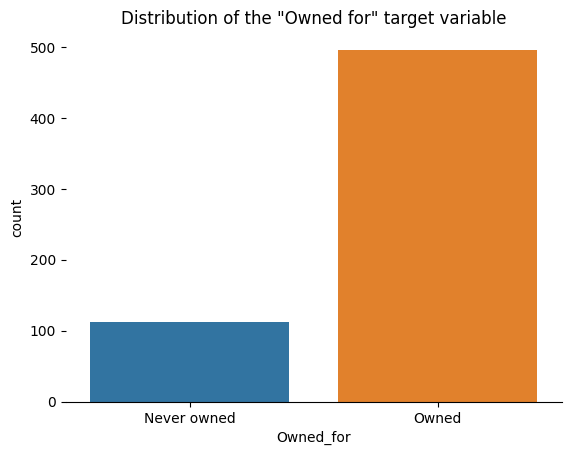

In [248]:
#Distribution of the target variable Owned for.
#As can be seen, there is only 18.4% of people reviews who has never owned a moped before.
display(data['Owned_for'].value_counts(normalize = True))
sns.countplot(x=data['Owned_for'])
plt.title('Distribution of the "Owned for" target variable')
plt.show()

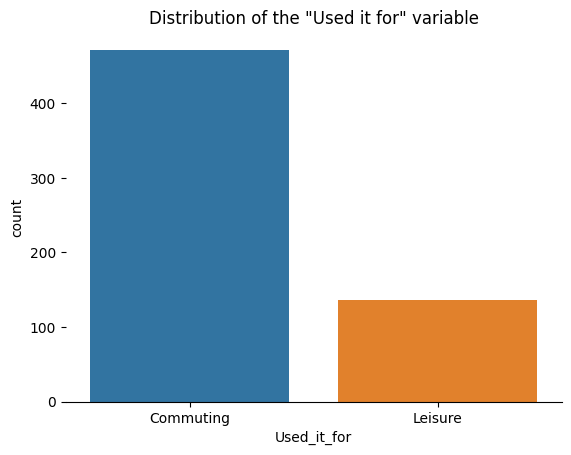

In [249]:
#Distribution of the variable Used it for.
#As can be seen, most of the people use the vehicle for commuting rather than leisure.
sns.countplot(data = data, x='Used_it_for')
plt.title('Distribution of the "Used it for" variable')
plt.show()

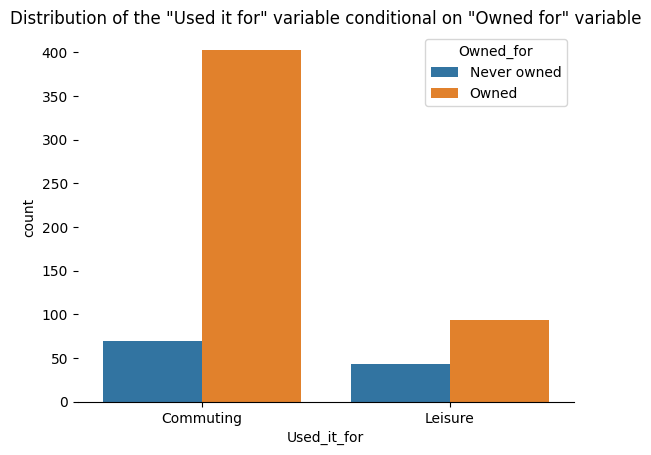

In [250]:
#If we inspect this variable based on the target, we see there is higher proportion of the people who never owned the moped before if they use the vehicle for leisure, compared to those who use the vehicle for commuting.
sns.countplot(data = data, x='Used_it_for', hue = 'Owned_for')
plt.title('Distribution of the "Used it for" variable conditional on "Owned for" variable')
plt.show()

Commuting    0.8125
Leisure      0.1875
Name: Used_it_for, dtype: float64
Commuting    0.616071
Leisure      0.383929
Name: Used_it_for, dtype: float64


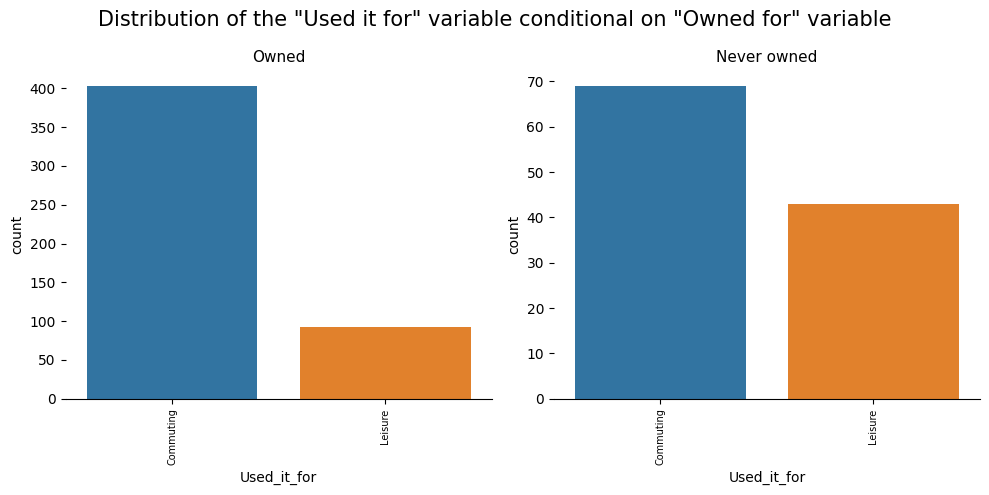

In [251]:
#The proportion of people using vehicle for leisure who never owned a moped before is higher by 19.64 percentage points compared to the people using vehicle for leisure who owned a moped before.
fig, axs = plt.subplots(nrows = 1,ncols = 2, figsize = (10, 5))
for i, ax in zip(['Owned', 'Never owned'], axs.ravel()):
    sns.countplot(data = data.query(f'Owned_for == "{i}"'), x = 'Used_it_for', order = data.query(f'Owned_for == "{i}"')['Used_it_for'].value_counts().index, ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 7)
    ax.set_title(i, fontsize = 11)
    print(data.query(f'Owned_for == "{i}"')['Used_it_for'].value_counts(normalize = True))
    
plt.suptitle('Distribution of the "Used it for" variable conditional on "Owned for" variable', size = 15)
plt.tight_layout()
plt.show()

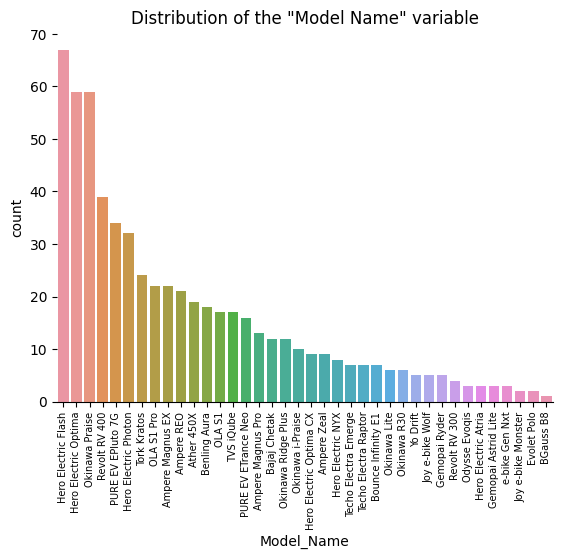

In [252]:
#Distribution of the Model Name variable.
#The most used vehicles are Hero Electric Flash, Hero Electric Optima and Okinawa Praise.
sns.countplot(data = data, x = 'Model_Name', order = data['Model_Name'].value_counts().index)
plt.xticks(rotation=90, size = 7)
plt.title('Distribution of the "Model Name" variable')
plt.show()

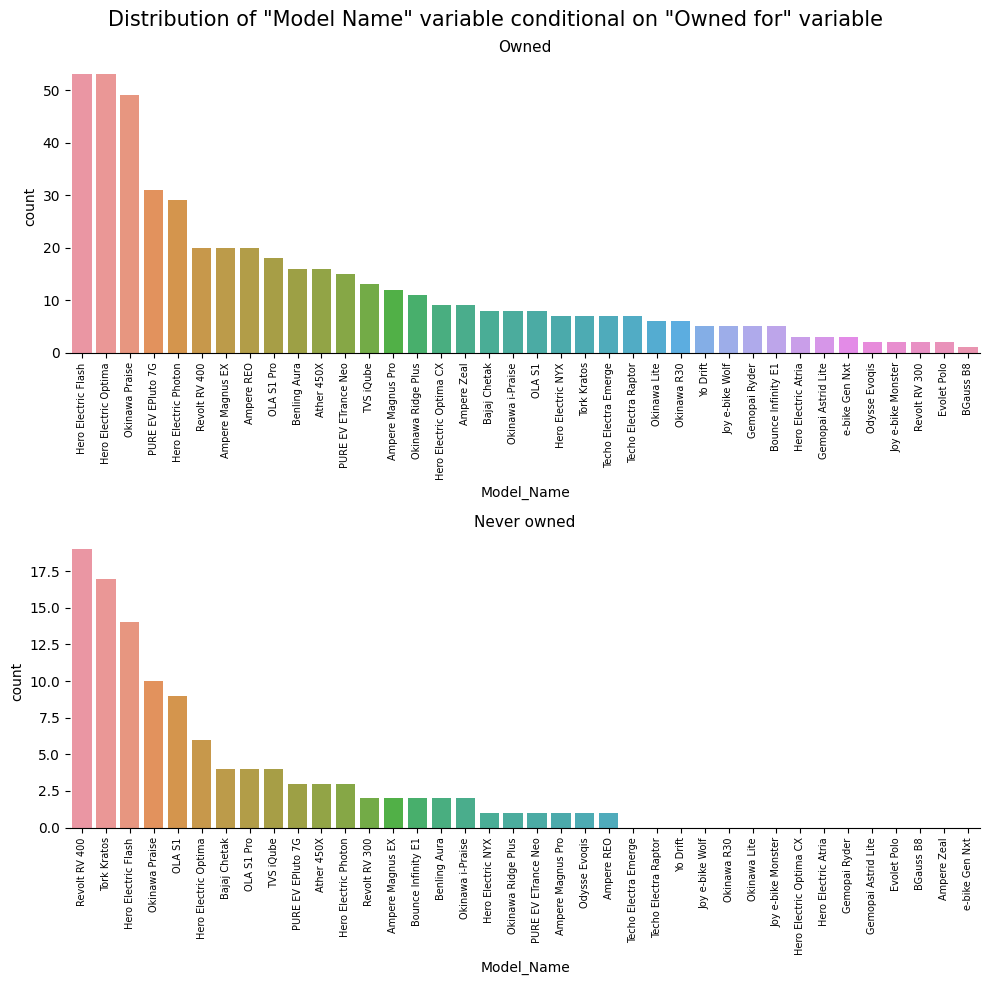

In [253]:
#If we again distinguish the Model name based on the target variable, we can observe that people who owned a moped before mostly have 'Hero Electric Flash', 'Hero Electric Optima' or 'Okinawa Praise'
#Whereas people who never owned a moped before mostly have 'Revolt RV 400', 'Tork Kratos' or 'Hero Electric Flash'

fig, axs = plt.subplots(nrows = 2,ncols = 1, figsize = (10, 10))
for i, ax in zip(['Owned', 'Never owned'], axs.ravel()):
    sns.countplot(data = data.query(f'Owned_for == "{i}"'), x = 'Model_Name', order = data.query(f'Owned_for == "{i}"')['Model_Name'].value_counts().index, ax = ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 7)
    ax.set_title(i, fontsize = 11)

plt.suptitle('Distribution of "Model Name" variable conditional on "Owned for" variable', size = 15)
plt.tight_layout()
plt.show()

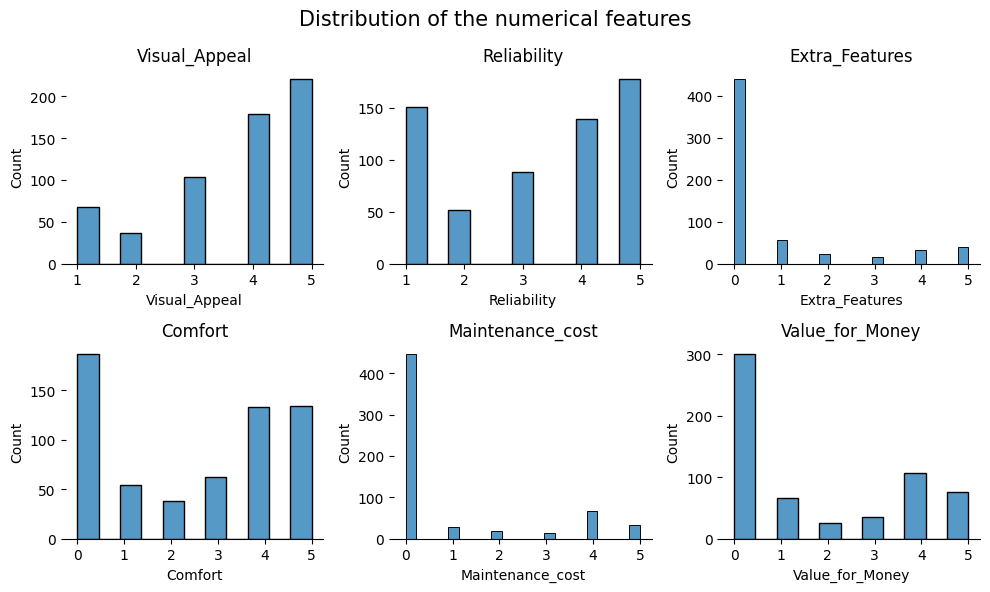

In [254]:
#Distribution of numerical features.
#Regarding Extra Features, Comfort, Maitenance_cost and Value_for_Money features, most of the people review have a missing values.
#Most of the reviews say that the Visual Appeal have the highest rating (5) as well as the reliability rating (5)
fig, axs = plt.subplots(nrows = 2,ncols = 3, figsize = (10, 6))
for i, ax in zip(numer_list, axs.ravel()):
    sns.histplot(data[i],  ax = ax)
    ax.set_title(i)
plt.suptitle('Distribution of the numerical features', size = 15)
plt.tight_layout()
plt.show()

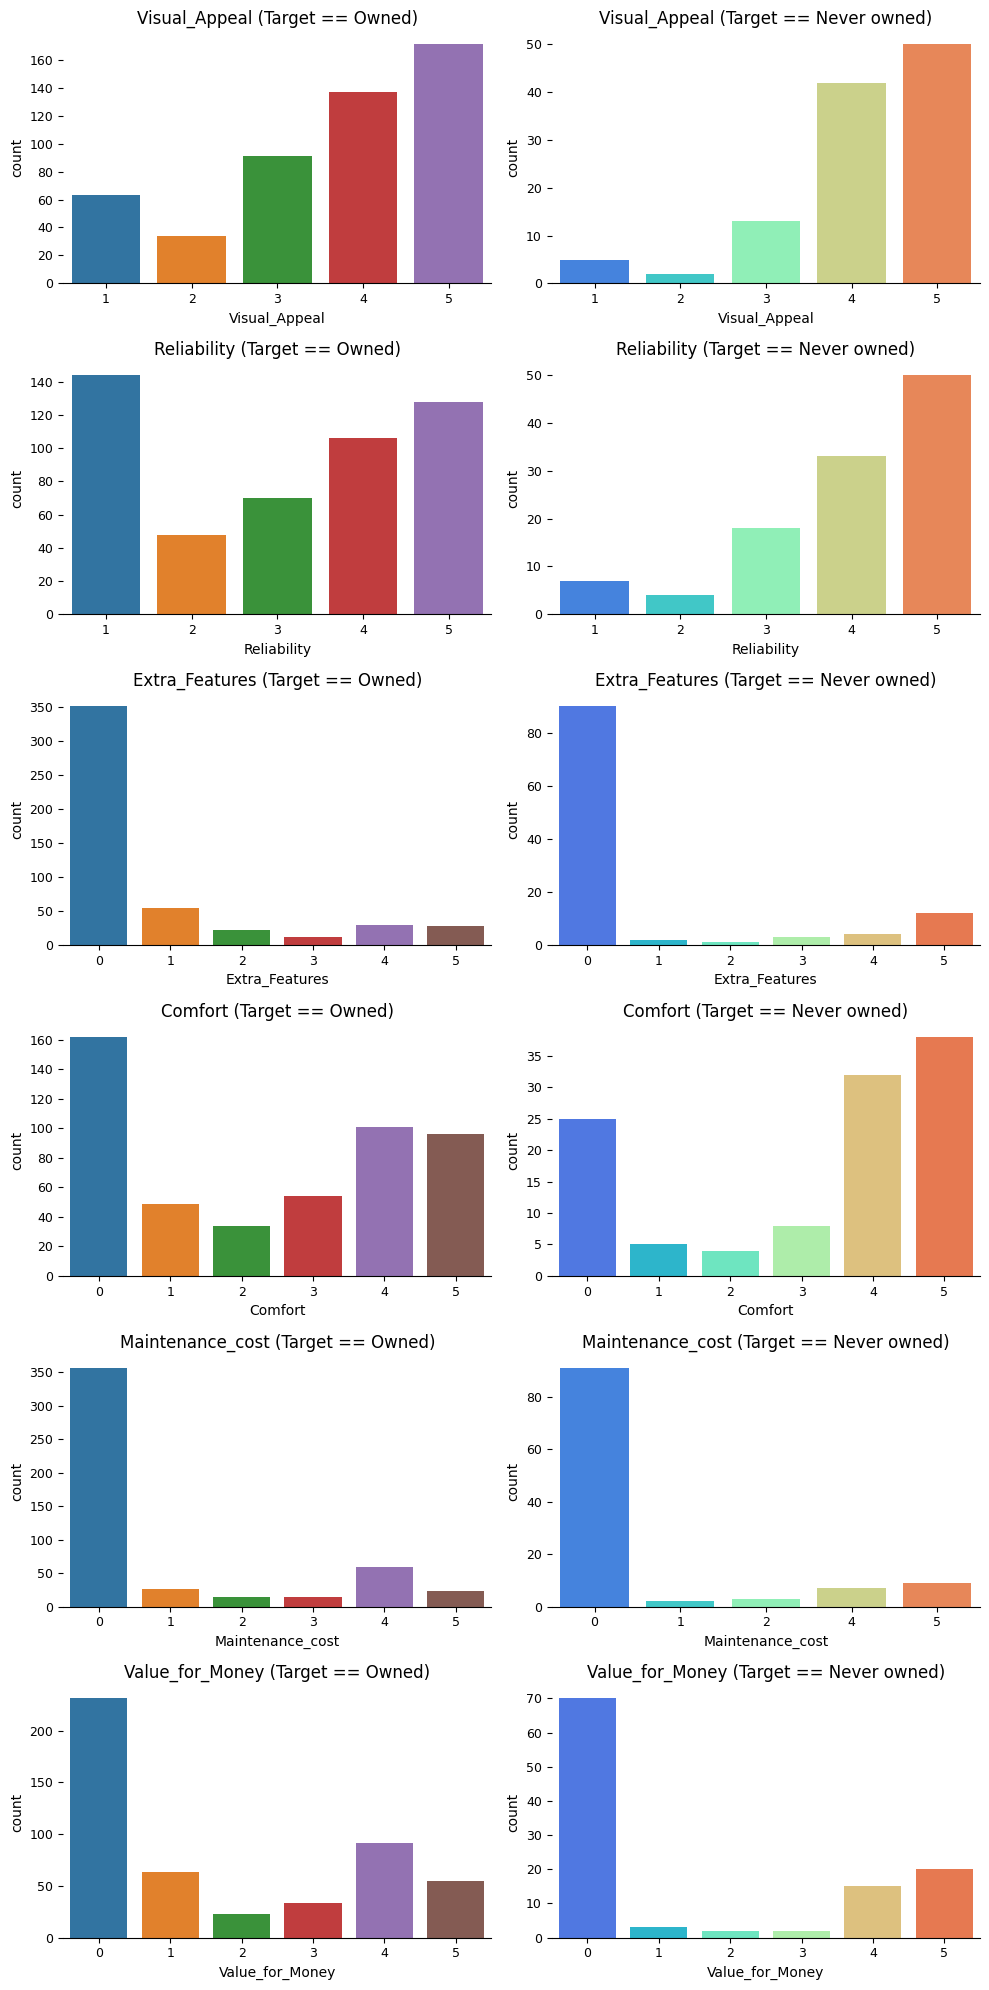

In [255]:
#Distinguishing the numerical features based on the target.
#It's interesting regarding Reliability, that almost or most of the people who owned a moped before give the worst rating (1), whereas the people who never owned a moped before mostly give the best rating (5) in contrast. Therefore, the people who owned a moped before do not consider the reliability of vehicle as satisfactory.

fig, axs = plt.subplots(nrows = 6,ncols = 2, figsize = (10, 20))
col_ind=0
axis_count = 0

for ax in axs.ravel():

    if axis_count % 2 == 0:
        sns.countplot(data=data[data["Owned_for"] == 'Owned'], x=numer_list[col_ind], ax = ax)
        ax.set_title(numer_list[col_ind]+" (Target == Owned)")
        ax.tick_params(axis='both', which='major', labelsize=9)
        
    else:
        sns.countplot(data=data[data["Owned_for"] == 'Never owned'], x=numer_list[col_ind], ax = ax, palette='rainbow')
        ax.set_title(numer_list[col_ind]+" (Target == Never owned)")
        ax.tick_params(axis='both', which='major', labelsize=9)

        col_ind += 1
        
    axis_count +=1
    

plt.tight_layout()
plt.show()

In [256]:
#We also perform a correlation/association analysis - we use Cramers V for association between categorical variables, and point biserial correlation for association between categorical and numerical variables.

#We always calculate the measure with respect to the target variable Owned for.
#As can be seen, the Model name is the most positively associated with the target variable. Thus, there can be observed particular dependence between those two variables.

#Further, Reliability is (not strongly) negatively associated with the target as well as the Comfort or Visual Appeal.
#Used it for variable has not strong but positive association with the target.
#Other variables depict low association with respect to the target.

corr_df = pd.DataFrame(columns = ['feature', 'corr', 'type'])

temp = data.copy().drop('Owned_for', axis = 1)

for i, col in enumerate(temp.columns):
    if col not in numer_list:
        data_crosstab = pd.crosstab(data['Owned_for'], temp[col])
        chi2, _, ___, ____ = chi2_contingency(data_crosstab, correction=False)
        cramer = np.sqrt(chi2/data_crosstab.sum().sum()/(min(data_crosstab.shape) -1))
        corr_df.loc[i,['feature', 'corr', 'type']] = col, cramer, "Cramers V"
    else:
        pointbis = pointbiserialr([1 if i == 'Owned' else 0 for i in data['Owned_for']], temp[col])[0]
        corr_df.loc[i,['feature', 'corr', 'type']] = col, pointbis, "Point biserial"
        
display(corr_df.reindex(corr_df['corr'].abs().sort_values(ascending = False).index))

,feature,corr,type
1,Model_Name,0.441221,Cramers V
3,Reliability,-0.242565,Point biserial
0,Used_it_for,0.182732,Cramers V
5,Comfort,-0.159232,Point biserial
2,Visual_Appeal,-0.153451,Point biserial
6,Maintenance_cost,0.047173,Point biserial
7,Value_for_Money,0.032207,Point biserial
4,Extra_Features,-0.002109,Point biserial


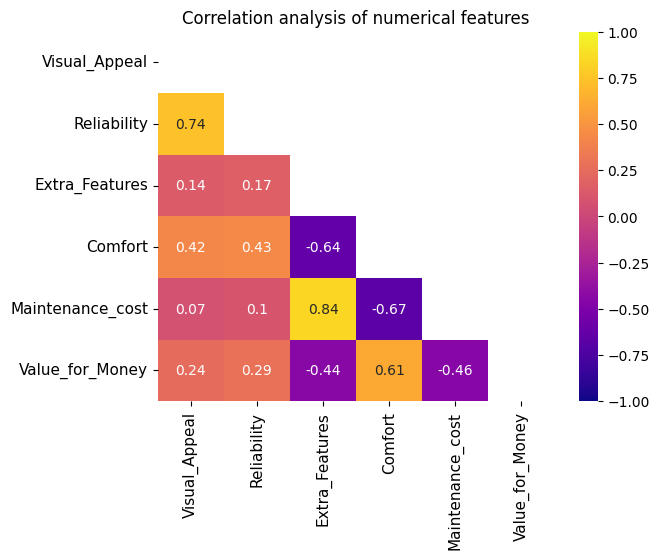

In [257]:
#If we explore the numerical features themselves with Pearson correlation coefficient, we can observe that Value for Money is strongly positively correlated with Comort and strongly negatively correlated with Extra Features and Maintenance cost. Besides that Maintenance cost is strongly positively correlated with Extra Features, and Comfort strongly negatively correlated with Extra features and strongly positively correlated with Reliability and Visual appeal. Further, Reliability is strongly positively correlated with Reliability.
plt.figure()
mask = np.triu(np.ones_like(data[numer_list].corr()))
cax = sns.heatmap(data[numer_list].corr(), vmin = -1, vmax = 1, mask = mask, cmap = "plasma", annot = True)
cax.tick_params(labelsize = 11)
cax.set_title('Correlation analysis of numerical features')
plt.show()

In [258]:
#Mapping the target classes into 0/1 values suitable for modelling.
data['Owned_for'] = [1 if i == 'Owned' else 0 for i in data['Owned_for']]

In [259]:
#Splitting the data into training and test sets with a stratification in order to preserve the same distribution of target across the samples.
seed = 42
X = data.drop('Owned_for',axis = 1)
Y = data[['Owned_for']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size = 0.2, random_state = seed)

print('number of training set instances:', X_train.shape[0])
print('number of test set instances:', X_test.shape[0])

number of training set instances: 486
number of test set instances: 122


In [260]:
#Since we have an imbalanced class, we perform an oversampling using SMOTE.
cat_index = [ind for ind, i in enumerate(X_train.columns) if i not in numer_list]

smotenc = SMOTENC(random_state=seed, categorical_features=cat_index)
X_train_os, y_train_os = smotenc.fit_resample(X_train, pd.DataFrame(y_train))

print('Distribution of the target variable after an oversampling:')
display(y_train_os.value_counts())

Distribution of the target variable after an oversampling:


Owned_for
0            396
1            396
dtype: int64

In [261]:
#list of categorical features
cat_list = [i for i in X_train_os.columns if i not in numer_list]

In [262]:
#Optimal binning of features with respect to the target. Transformation of the training and test sets based on training set.
#it discretizes the numeric features into interval bins and groups the categorical features into subgroups as categorical bins.
bn = BinningProcess(variable_names = list(X_train_os.columns), categorical_variables = cat_list)

bn.fit(X_train_os,y_train_os['Owned_for'])

#Binning and WoE encoding. Such bins are then encoded using Weight-of-Evidence.
X_train_binned = bn.transform(X_train_os, metric='woe')
X_train_binned.index = X_train_os.index

X_test_binned = bn.transform(X_test, metric='woe')
X_test_binned.index = X_test.index

In [263]:
#Displaying the bins per each feature.
bins_woe = pd.DataFrame()
for i in X_train_os.columns:
        
        var = bn.get_binned_variable(i).binning_table.build()
        var = var[(~var['Bin'].isin(['Special', 'Missing'])) & (~var.index.isin(['Totals']))]
        var['Variable'] = i

        bins_woe = pd.concat((bins_woe, var))
        
display(bins_woe)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Variable
0,[Leisure],200,0.252525,125,75,0.375000,0.510826,0.064498,0.007976,Used_it_for
1,[Commuting],592,0.747475,271,321,0.542230,-0.169322,0.021379,0.002669,Used_it_for
0,[Tork Kratos],99,0.125000,95,4,0.040404,3.167583,0.727904,0.065490,Model_Name
1,[OLA S1],61,0.077020,55,6,0.098361,2.215574,0.274149,0.028627,Model_Name
2,"[Revolt RV 300, Revolt RV 400]",94,0.118687,77,17,0.180851,1.510592,0.228878,0.026166,Model_Name
3,"[Bajaj Chetak, Hero Electric Flash]",115,0.145202,68,47,0.408696,0.36936,0.019587,0.002435,Model_Name
4,[Okinawa Praise],83,0.104798,41,42,0.506024,-0.024098,0.000061,0.000008,Model_Name
5,"[Okinawa i-Praise, OLA S1 Pro, Ather 450X]",52,0.065657,20,32,0.615385,-0.470004,0.014243,0.001764,Model_Name
6,"[Hero Electric Optima, Bounce Infinity E1]",76,0.095960,26,50,0.657895,-0.653926,0.039632,0.004868,Model_Name
7,"[Hero Electric Photon, TVS iQube, Ampere Magnu...",47,0.059343,7,40,0.851064,-1.742969,0.145247,0.016158,Model_Name


In [264]:
display(X_train_binned)

,Used_it_for,Model_Name,Visual_Appeal,Reliability,Extra_Features,Comfort,Maintenance_cost,Value_for_Money
0,0.510826,3.167583,-0.745791,-1.159767,0.137570,-0.543335,0.125163,0.330242
1,0.510826,-2.505526,0.204794,0.558172,0.419854,-0.543335,-0.195309,0.330242
2,-0.169322,-3.592736,0.296732,0.218818,0.137570,0.523248,0.125163,0.040274
3,-0.169322,-0.653926,-0.438913,-1.159767,0.137570,-0.416160,0.125163,-2.871680
4,-0.169322,-3.592736,-0.438913,0.218818,-1.261131,-0.543335,-0.800778,0.330242
...,...,...,...,...,...,...,...,...
787,0.510826,3.167583,0.296732,0.558172,0.137570,0.523248,0.125163,0.330242
788,0.510826,0.369360,0.204794,0.558172,0.137570,0.482252,0.125163,0.330242
789,0.510826,-0.470004,-0.438913,-1.123930,0.137570,-0.543335,0.125163,0.330242
790,-0.169322,-0.024098,0.296732,0.218818,0.137570,-0.416160,0.125163,0.040274


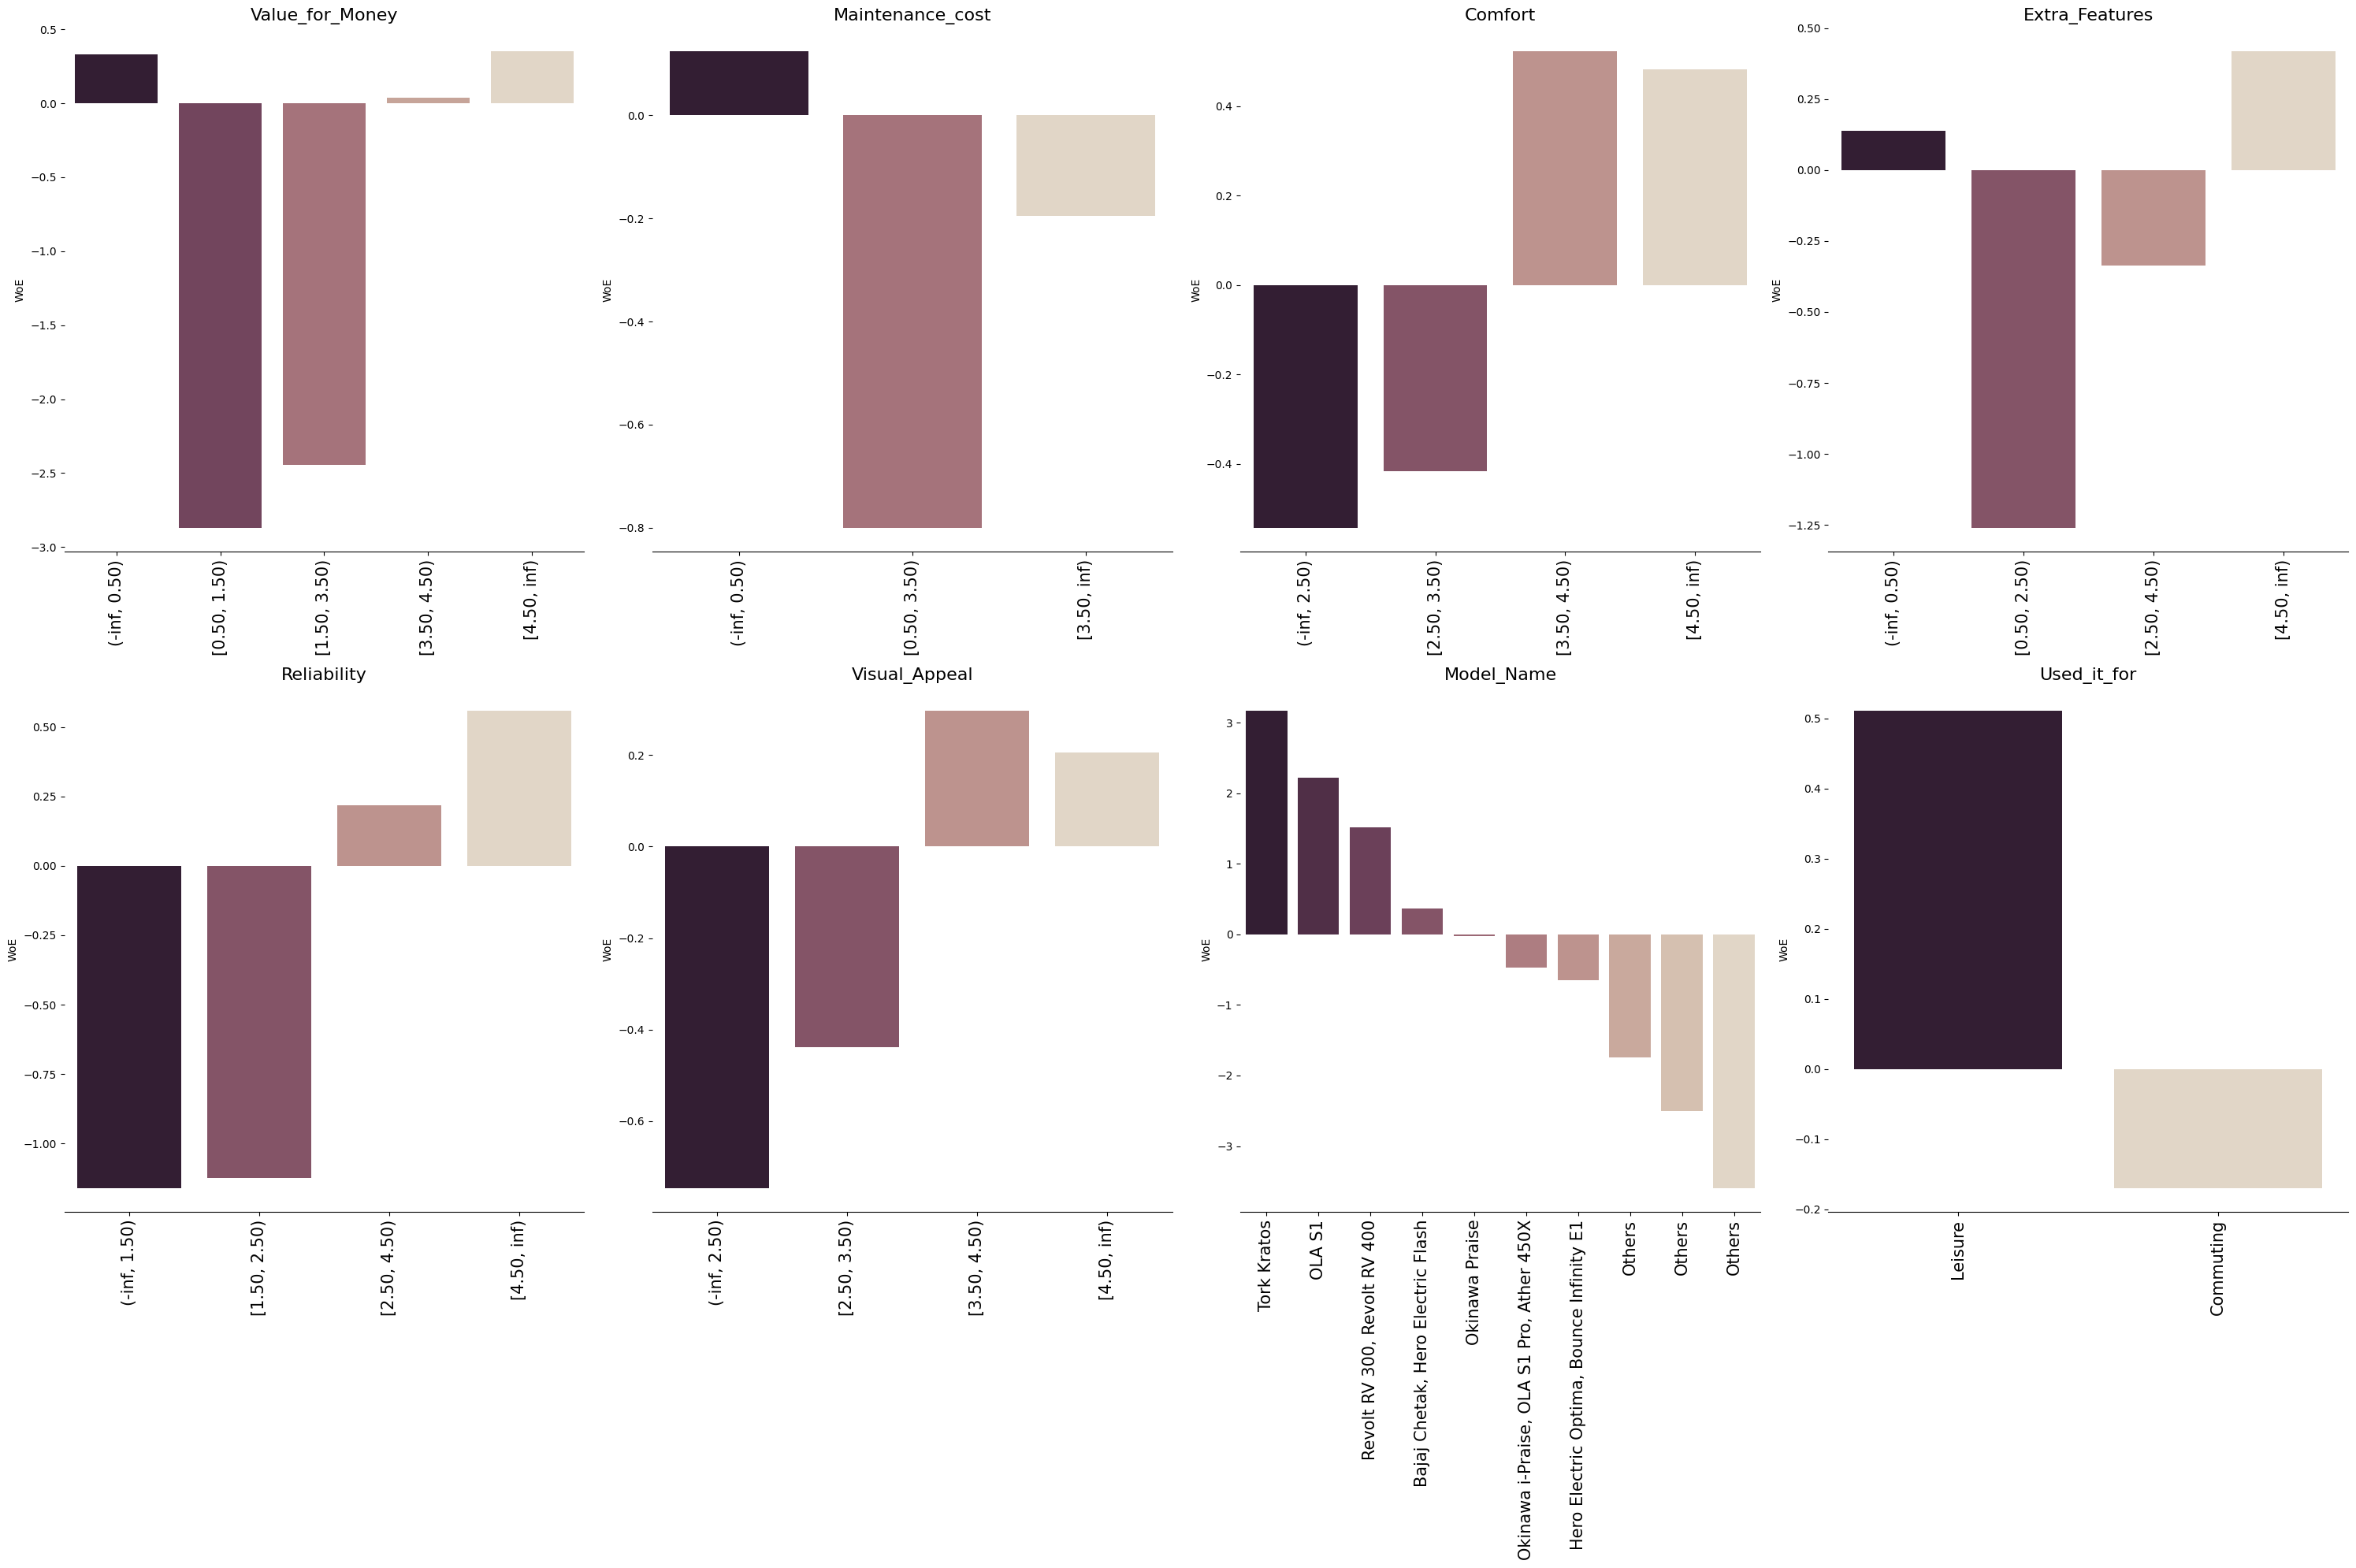

In [265]:
#WoE distribution
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (30, 20))

for i, ax in zip(list(X_train_binned.columns)[::-1], axs.ravel()):
    
    temp = bins_woe.loc[bins_woe['Variable'] == i]
    sns.barplot(x = temp.index, y = 'WoE', data = temp, ax = ax, palette = "ch:.25_r")
    cat = False
    
    for j in temp['Bin']:
        if isinstance(j, np.ndarray):
            cat = True
            break
    if cat == False:
        labels = list(temp['Bin'])
	
    elif cat == True:
        labels = [str(k.tolist()).replace('[','').replace(']','').replace("'",'') for k in temp['Bin']]
        labels = [i if len(i) < 50 else 'Others' for i in labels]
        
    ax.set_title(i, size = 16)
    ax.set_xticklabels(labels,rotation=90,size=15)
fig.tight_layout()
plt.show()

## Exploratory Analysis
Describe what you found in the exploratory analysis. In your description you should:
- Reference at least two different data visualizations you created above to demonstrate the characteristics of single variables
- Reference at least one data visualization you created above to demonstrate the relationship between two or more variables
- Describe what your exploratory analysis has told you about the data
- Describe any changes you have made to the data to enable modeling

1) *We convert character variables into categories data types from object data types for effective manipulation, as well as the converting numeric variables from floats to integers*.
2) *We can observe an imbalanced distribution of the target variable Owned for whereby there is a majority of people who owned a moped before (81.6%).*
3) *Most of the people use a vehicle for commuting, however, there is a difference in the relatve proportions with respect to the target variable - Relatively, there are more people who are using vehicle for leisure in the group of people who never owned a moped before compared to the group of people who owned a moped before - the difference is 19.64 percentage points.*
4) *People mostly have vehicles Electric Flash, Hero Electric Optima or Okinawa Praise. This also applies for the subset of people who owned a moped before. However, the people who never owned a moped before mostly have Revolt RV 400, Tork Kratos or Hero Electric Flash. Therefore we can spot the difference when it comes to the models of vehicle.*
5) *Most of the people reviews have missing values with respect to the extra features, comfort, maitenance cost and value for money variables. Also most of the people reviews have very positive rating of the visual appeal and reliability rating as both have scored mostly with the grade 5. Therefore, people who already owned a moped before, thus they have already some experience, can tell whether the vehicle is reliable or not, whereas people who never owned a moped before cannot.*
6) *Following the previous finding, we can observe difference between the group of people who owned a moped before and the group of people who never owned a moped before. Particuarly, we can observe difference when it comes to the Reliability as the people who owned a moped before mostty give the worst rating (1) whereas the people who never owned a moped before mostly give the best rating (5)*
7) *About the associations, the target variable Owned for is strongly associated with Model Name variable and also with Reliability or Used it for. We can expect these variables will be in some way important during the modelling.*
8) *We convert target to Boolean 0/1 values which is more suitable for modelling.*
9) *We split the data into training set (80%) for building the model and test set (20%) for evaluation of the model. Due to very low number of observation, we omit the validation set. We split data with stratification of the target in order to preserve the same distribution of the target across the sets.*
10) *Since we have an imbalanced distribution of the target variable, we perform an oversampling using SMOTE in order to balance the distribution. We perform oversampling on the training set only in order to avoid a data leakage.*
11) *As a preprocessing of features, we use optimal binning which groups the categorical variables' values' into optimal subgroups(bins) and discretizes the numerical features into intervals (bins).*
12) *Such bins are then transformed using WoE-of-Evidence encoding. Such preprocessing is transforming training set and test set based on training set. Negative WoE values indicate larger distribution of people who owned moped before in given bin, positive WoE values indicate larger distribution of people who never owned moped in given bin.*

In [266]:
#Initializing ML models - random forest classifier and logistic regression.
lr = LogisticRegression(random_state = seed)
rf = RandomForestClassifier(random_state = seed)

In [267]:
#Defining hyperparemters' values' space for each model - input for hyperparameter tuning.
lr_params  = {
              'fit_intercept':  Categorical([True, False]),
              'C': Real(0.0001, 10)}

rf_params = {'n_estimators': Integer(500, 2000),
             'criterion': Categorical(['gini', 'entropy']),
              'max_depth': Integer(1, 50),
            'max_features': Integer(1, 8),
            'min_samples_leaf': Integer(5, 500)}

In [268]:
#Defining a function for hyperparameter tuning of input model based on input hyperparameter values' space. Tuning is performed using Bayesian optimization with stratified 10 fold cross validation.
def bayes_tuning(model, params, x, y, seed):
    
    cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
    
    bayescv = BayesSearchCV(estimator = model,
                            search_spaces = params,
                            scoring = "f1", cv = cv,
                            n_jobs = -1, n_iter = 100,
                            verbose = 1, refit = True,
                            random_state = seed)
    
    bayescv.fit(x,y)
    
    return bayescv.best_estimator_

In [269]:
#Tuning of logistic regression
lr_tuned = bayes_tuning(lr, lr_params, X_train_binned, y_train_os, seed)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [270]:
#Tuning of random forest
rf_tuned = bayes_tuning(rf, rf_params, X_train_binned, y_train_os, seed)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [271]:
#Building a tuned logistic regression
lr_tuned.fit(X_train_binned, y_train_os)

LogisticRegression(C=0.030854675710550783, fit_intercept=False, random_state=42)

In [272]:
#Building a tuned random forest
rf_tuned.fit(X_train_binned, y_train_os)

RandomForestClassifier(criterion='entropy', max_depth=9, max_features=5,
                       min_samples_leaf=6, n_estimators=1008, random_state=42)

## Model Fitting
Describe your approach to the model fitting. In your description you should:
- Describe what type of machine learning problem you are working on
- Describe which method you selected for the baseline model and explain why you chose this model
- Describe which method you selected for the comparison model and explain why you chose this model

1) *Since we want to predict which reviews come from people who have never owned the moped before - thus, we want to predict based on review whether the person owned a moped before or not, we will use (binary) classification ML algorithms.*
2) *As a base model, we use a logistic regression and as a comparison model we choose random forest classifier. The former we choose because it is one of the most traditional, basic and transparent models and the latter we choose because it is very complex and almost a blackbox model with very difficult interpretation compared to the logistic regression. We expect the random forest would outperform logistic regression.*
3) *We tune each model's hyperparameters using Bayesian Optimization and 10-fold stratified cross validation while maximing F1 score on the training set. Then, we build final models using these tuned models by fitting them on the training set.*

In [273]:
#Defining metrics space
metrics = {'F1': f1_score,
                'Precision': precision_score, 
                'Recall': recall_score, 
                'Accuracy': accuracy_score,
                'AUC': roc_auc_score,
                'Gini': roc_auc_score,
                'KS': ks_2samp, 
                'Brier': brier_score_loss}
probs_evs = ['AUC','Brier']
class_evs = ['Precision','Recall','F1', 'Accuracy']

#Defining the model space
model_space = {'LR':lr_tuned, 'RF':rf_tuned}

In [274]:
#Function for displaying confusion matrix as a data frame with annotations.
def conf_mat(y_true, model, sample):

    confm = pd.DataFrame(confusion_matrix(y_true, model.predict(sample))).rename(
                                            columns = {0: 'Predicted - Never owned',1: 'Predicted - Owned'},
                                            index = {0: 'Actual - Never owned', 1: 'Actual - Owned'})
    
    return confm

In [275]:
#Function which outputs data frame of scores for each metric defined above. The scores are calculated for both models on the test set.
def eval_df(models, x_test, y_test, metrics):
    
    ev_final = pd.DataFrame({'Metric':list(metrics.keys())})
    
    for name,model in models.items():
        evs_list = []
        for met in metrics.keys():
            if met in probs_evs:
                evs_list.append([met, metrics[met](y_test, model.predict_proba(x_test)[:, 1])])
            elif met in class_evs:
                evs_list.append([met, metrics[met](y_test, model.predict(x_test))])
            elif met == 'Gini':
                evs_list.append([met, 2 *  metrics[met](y_test, model.predict_proba(x_test)[:, 1]) - 1])
            elif met == 'KS':
                X_Y_concat = pd.concat((y_test, x_test), axis=1)
                X_Y_concat['prob'] =  model.predict_proba(x_test)[:, 1]
                evs_list.append([met,  metrics[met](X_Y_concat.loc[X_Y_concat['Owned_for'] == 1, 'prob'],
                                                 X_Y_concat.loc[X_Y_concat['Owned_for'] == 0, 'prob'])[0]])
        ev = pd.DataFrame(evs_list, columns = ['Metric', f'Score_{name}'])
        ev_final = ev_final.merge(ev, on='Metric')
    return ev_final

In [276]:
evaluation = eval_df(model_space, X_test_binned, y_test, metrics)
display(evaluation)

,Metric,Score_LR,Score_RF
0,F1,0.764045,0.797814
1,Precision,0.871795,0.879518
2,Recall,0.680000,0.730000
3,Accuracy,0.655738,0.696721
4,AUC,0.649091,0.705000
5,Gini,0.298182,0.410000
6,KS,0.285455,0.367273
7,Brier,0.214668,0.202524


In [277]:
#As can be seen, random forest outperforms the logistic regression across all the metrics while using the the default threshold of 0.5.

#On the confusion metrices below, it can be seen that using a default threshold, random forest outperforms logistic regression when it comes to the True Positives (i.e., people who actually owned a moped before classified as they owned a mpoed before).

In [278]:
print('Random forest:')
display(conf_mat(y_test, rf_tuned, X_test_binned))
print('Logistic regression:')
display(conf_mat(y_test, lr_tuned, X_test_binned))

Random forest:


,Predicted - Never owned,Predicted - Owned
Actual - Never owned,12,10
Actual - Owned,27,73


Logistic regression:


,Predicted - Never owned,Predicted - Owned
Actual - Never owned,12,10
Actual - Owned,32,68


In [279]:
#In previous case, we're performing the classification/prediction with a default threshold of 0.5. Such threshold is not very common in real life, therefore we calculate own threshold which should be optimal as search for a minimum of a absolute difference between the true positive rate and true negative rate. Noted that true negative rate is equivalent to 1 - false positive rate. Based on such optimal threshold we then compute new metrics derived from confusion metrics. However, this won't influence probabilistic metrics.
#We compute the optimal threshold for each model.
def eval_df_opt(models, x_test, y_test, metrics):
    
	ev_final = pd.DataFrame({'Metric':list(metrics.keys())})
    
	for name,model in models.items():
        
		evs_list_thres = []
		y_preds_proba = model.predict_proba(x_test)[:,1]
		fpr, tpr, thresholds =roc_curve(y_test, y_preds_proba)
		diff = abs(tpr - (1-fpr))
		threshold = thresholds[np.argmin(diff)]
		y_preds = pd.Series(y_preds_proba).apply(lambda x: 1 if x > threshold else 0)
        
		print(f'Optimal threshold for {name}: {round(threshold, 4)}')
        
		for met in metrics.keys():
			if met in probs_evs:
				evs_list_thres.append([met, metrics[met](y_test, model.predict_proba(x_test)[:, 1])])
			elif met in class_evs:
				evs_list_thres.append([met, metrics[met](y_test, y_preds)])
			elif met == 'Gini':
				evs_list_thres.append([met, 2 *  metrics[met](y_test, model.predict_proba(x_test)[:, 1]) - 1])
			elif met == 'KS':
				X_Y_concat = pd.concat((y_test, x_test), axis=1)
				X_Y_concat['prob'] =  model.predict_proba(x_test)[:, 1]
				evs_list_thres.append([met,  metrics[met](X_Y_concat.loc[X_Y_concat['Owned_for'] == 1, 'prob'],X_Y_concat.loc[X_Y_concat['Owned_for'] == 0, 'prob'])[0]])
		ev_tr = pd.DataFrame(evs_list_thres, columns = ['Metric', f'Score_{name}'])
        
		ev_final = ev_final.merge(ev_tr, on='Metric')
        
	return ev_final.reindex(sorted(ev_final.columns), axis=1)

In [280]:
#Function for displaying confusion matrix as a data frame with annotations, using optimal threshold.
def conf_mat_v2(y_true, model, sample, opt = False):
    if opt:
        y_preds_proba = model.predict_proba(sample)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_true, y_preds_proba)
        diff = abs(tpr - (1-fpr))
        threshold = thresholds[np.argmin(diff)]
        y_preds = pd.Series(y_preds_proba).apply(lambda x: 1 if x > threshold else 0)
    else:
        y_preds = model.predict(sample)
    confm = pd.DataFrame(confusion_matrix(y_true, y_preds)).rename(columns = {0: 'Predicted - Never owned', 1:'Predicted - Owned'},
                                                                    index = {0:'Actual - Never owned', 1:'Actual - Owned'})

    return confm

In [281]:
#We see the optimal thresholds are higher than default threshold 0.5 for both models.
evaluation_opt = eval_df_opt(model_space, X_test_binned, y_test, metrics)

Optimal threshold for LR: 0.7376
Optimal threshold for RF: 0.8268


In [282]:
display(evaluation_opt)

,Metric,Score_LR,Score_RF
0,F1,0.698795,0.748538
1,Precision,0.878788,0.901408
2,Recall,0.580000,0.640000
3,Accuracy,0.590164,0.647541
4,AUC,0.649091,0.705000
5,Gini,0.298182,0.410000
6,KS,0.285455,0.367273
7,Brier,0.214668,0.202524


In [283]:
evaluation_final = evaluation.merge(evaluation_opt, on = 'Metric', suffixes = ('_def', '_opt'))[['Metric', 'Score_LR_def','Score_LR_opt','Score_RF_def','Score_RF_opt']]

In [284]:
display(evaluation_final)

,Metric,Score_LR_def,Score_LR_opt,Score_RF_def,Score_RF_opt
0,F1,0.764045,0.698795,0.797814,0.748538
1,Precision,0.871795,0.878788,0.879518,0.901408
2,Recall,0.680000,0.580000,0.730000,0.640000
3,Accuracy,0.655738,0.590164,0.696721,0.647541
4,AUC,0.649091,0.649091,0.705000,0.705000
5,Gini,0.298182,0.298182,0.410000,0.410000
6,KS,0.285455,0.285455,0.367273,0.367273
7,Brier,0.214668,0.214668,0.202524,0.202524


In [285]:
#As can be seen, though F1 score has decreased because of the decrease in recall, however the precision has increased for both models which is desired since we reduced the number of false positive instances/increased number of true negative instances - in other words, we reduced a number of people who never owned a moped before but we classified them as people who owned a moped before (false positive), and increased a number of people who never owned a moped before and we correctly classified them that they never owned a moped before (true negative). New threshold did not influence the probabilistic metrics.

#Thus, after setting and optimal threshold, the model is focusing more on those who have never owned a moped before which is desired based on manager's question. In conclusion, since after setting a new threshold, random forest outperforms logistic regression on both probabilistic and confusion matrix metric again, we choose the random forest as the best model.

In [286]:
print('Random forest with default threshold:')
display(conf_mat_v2(y_test, rf_tuned, X_test_binned))
print('Logistic regression with default threshold:')
display(conf_mat_v2(y_test, lr_tuned, X_test_binned))

print('Random forest with optimal threshold:')
display(conf_mat_v2(y_test, rf_tuned, X_test_binned, True))
print('Logistic regression with optimal threshold:')
display(conf_mat_v2(y_test, lr_tuned, X_test_binned, True))

Random forest with default threshold:


,Predicted - Never owned,Predicted - Owned
Actual - Never owned,12,10
Actual - Owned,27,73


Logistic regression with default threshold:


,Predicted - Never owned,Predicted - Owned
Actual - Never owned,12,10
Actual - Owned,32,68


Random forest with optimal threshold:


,Predicted - Never owned,Predicted - Owned
Actual - Never owned,15,7
Actual - Owned,36,64


Logistic regression with optimal threshold:


,Predicted - Never owned,Predicted - Owned
Actual - Never owned,14,8
Actual - Owned,42,58


In [287]:
def ROC_plot(model_dict,y_true, sample):
	for name, model in model_dict.items():
		y_pred = model.predict_proba(sample)[:, 1]
		fpr, tpr, _ = roc_curve(y_true, y_pred)
		auc = roc_auc_score(y_true, y_pred)
		plt.plot(fpr,tpr,label=f"{name} ... AUC = {auc*100:.2f}%")

	plt.plot([0, 1], [0, 1], 'r--')
	plt.ylabel('True Positive Rate')
	plt.xlabel('False Positive Rate')
	plt.title('ROC curves')
	plt.legend()
	plt.grid()


	plt.tight_layout()
	plt.show()

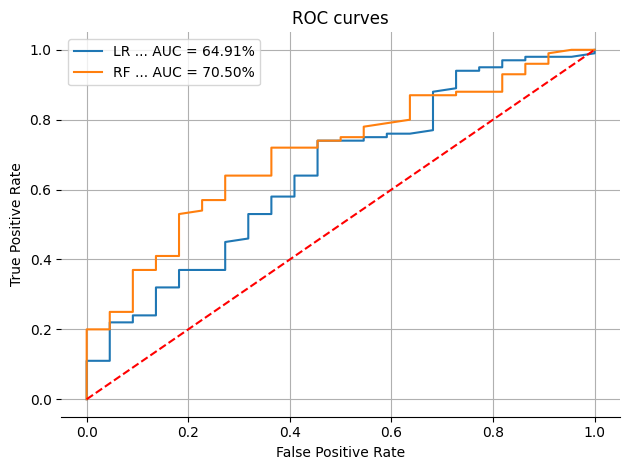

In [288]:
#We see that RF again outperforms logistic regression as it has higher area under ROC curve represented by AUC
ROC_plot(model_space,y_test, X_test_binned)

In [289]:
def FI_rf_plot(sample, rf_model):
	df_rf_fi = pd.DataFrame({'feature_names': sample.columns,'feature_importance': rf_model.feature_importances_}).sort_values(by=['feature_importance'], ascending=False)
	plt.figure()
	sns.barplot(x = df_rf_fi['feature_importance'], y = df_rf_fi['feature_names'])
	plt.title('Random forest - feature importance')
	plt.xlabel('Feature importance')
	plt.ylabel('Feature names')
	plt.show()

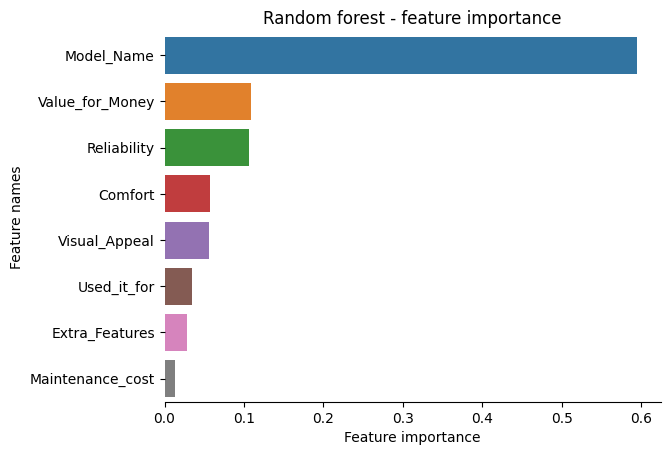

In [290]:
#If we plot the feature importances of the random forest, we can observe that the Model Name feature has the highest feature importance which is in line with our finind within exploratory analysis where the Model Name feature had the higher Cramers V coefficient.
FI_rf_plot(X_test_binned, rf_tuned)

In [291]:
def LR_coef_plot(sample, lr_model):
	coefs = pd.DataFrame([sample.columns,
                    lr_model.coef_.tolist()[0]]).transpose().rename(columns = {0: 'Feature', 1:'Beta'})
	fig, ax = plt.subplots()
	sns.barplot(data = coefs, y = 'Feature', x='Beta', ax = ax)
	ax.tick_params(axis='x', which='major', labelsize=9, rotation = 90)
	plt.title('Logistic regression - beta coefficients')
	plt.xlabel('Beta coefficients')
	plt.ylabel('Feature names')
	plt.show()

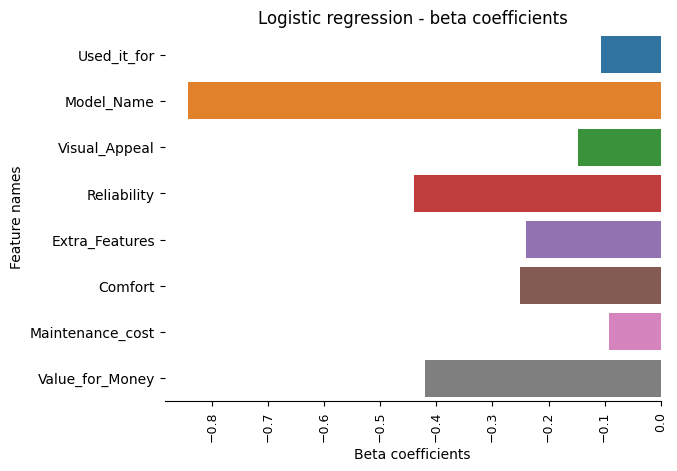

In [292]:
#If we plot the magnitudes of the beta coefficients of the logistic regression, we can again observe that the Model Name feature has the highest magnitude.
#All the coefficients are negative. Thus, using the sigmoid function, the higher (WoE) value of feature, the lower probability of being people who owned moped before/the higher probability of being people who never owned a moped before.
#In context of WoE, the conclusion is in line, since the higher the WoE value, meaning the more positive WoE, hence the larger distribution of people who never owned a moped before than people who  owned a moped before. This is thus consistent with that is leading to the lower probability of being people who owned moped before/the higher probability of being people who never owned a moped before.
LR_coef_plot(X_test_binned, lr_tuned)

## Model Evaluation
Explain what the results of your evaluation tell you. You should:
- Describe which metric you have selected to compare the models and why
- Explain what the outcome of this evaluation tells you about the performance of your models
- Identify, based on the evaluation, which you would consider to be the better performing approach

1) *We perform the evaluation of the models on test set.*
2) *We use traditional evaluation tool, a cofunsion matrix to display how many observations were classified correctly per target class.*
3) *Also we calculate metrics derived from confusion matrix such as accuracy, recall, precision or F1 score. However since the target is imbalanced, accuracy can be biased. Therefore precision and/or F1 should be the most important metrics as we want to also focus on the instances/people who never owned a moped before. Besides that, we alco compute metrices derived from the predicted scores/probabilities such as ROC-AUC, Gini coefficient, Brier score loss or Kolmogorov Smirnov distance. All these metrics are commonly used in credit risk modelling.*
4) *Regarding the confusion matrix and its metrics, it is based on the default threshold being 0.5 (if it's lower, then classify it as 0, else 1), which is not very common in real life. Therefore, we calculate an optimal threshold based on minimizing the absolute difference between true positive rate and true negative rate and use this threshold for classification again. Note that using different threshold will not influence the probabilistic metrics' results.* 
5) *Using the optimal threshold, in overall, the F1, accuracy, and recall decreased. However, the precision has increased which is desired. Using an optimal threshold, we are able to decrease number of false positives (people who never owned a moped before but were classified as people who owned a moped before) and increase number of true negatives (people who never owned a moped before and were classified as people who never owned a moped before).*
6) *Using either a default or optimal treshold, random forest outperforms logistic regression in terms of confusion matrix' metrics and probabilistic metrics.*
7) *We also construct ROC curves for both models and plot the feature importances for random forest and beta coefficients for logistic regression. For both models, the most important feature based on magnitude of coefficient/importance is Model Name which is in line with the finding in exploratory analysis.*
8) *Regarding logistic regression, all the coefficients are negative, thus using sigmoid function, the higher (WoE) value of feature, the lower probability of being people who owned moped before/the higher probability of being people who never owned a moped before.*
9) *As expected, this is also in line with WoE logic - the higher the WoE value, meaning the more positive WoE, hence the larger distribution of people who never owned a moped before than people who  owned a moped before. This is thus consistent with that is leading to the lower probability of being people who owned moped before/the higher probability of being people who never owned a moped before.*
10) *In conclusion, if we want a model which performs well, we would choose a random forest. However, if we are limited by regulations which emphasize for instance interpretability or model transparency (likewise in credit risk modelling), we would choose logistic regression. Since we do not assume any limitations, we would choose random forest as the best model, using and optimal threshold 0.8268 resulting in F1 score 0.7485, Precision 0.9014 and AUC 0.705. Such model has entropy criterion and 1008 trees with max features of 5, max depth of 9 and min samples leaf of 6.*
11) *In business, we would more focus on features such as Model Name, Value for Money or Reliability when it comes to predicting whether the person never owned a moped before. Such features would help us with a prediction.*

## Communation:
- _Validation_:
 	- Removing duplicates (105 duplicated rows).
    - The variables' values are in line with the data dictionary.
      - Used it for variable is character and has respective categories (commuting and leisure) as expected.
      - Owned for variable is character and has respective categories (<= 6 months, >6 months and Never owned) as expected. We then combined <= 6 months and >6 months categories into a single category Owned, in order to have a binary target class (Owned/Never owned).
      - Model Name variable is character and contains electric mopeds' names as expected which is in line with the data dictionary.
      - Visual Appeal, Reliability, Extra Features, Comfort, Mainentance cost and Value for money variable are numeric and have ratings ranging from 1 to 5 as expected. With regards to variables  Extra Features, Comfort, Mainentance cost and Value for money, those had missing values, which were then replaced with zeros as in line with the data dictioanary.
      - We also replaced spaces with underscores for more effective data manipulation.
- _Exploratory analysis_:
	- Conversion of character variables from object data type to category data type for more effective manipulation as well as the conversion numeric variables from floats to integers.
	- Majority of people who owned a moped before.
    - Most of people use vehicles for commuting.
    - Relatively there are more people using vehicles for leisure in the group of people who never owned a moped before than in the group of people who owned a moped before.
    - There are differences in these two groups when it comes to the model names (Revolt RV 400 or Tork Krators for the group of people who never owned a moped before, and Hero Electric Flash or Hero Electric Optima for the group of people who owned a moped before).
    - Most of the reviews say that the visual appeal have the highest rating (5) as well as the reliability rating (5).
    - Regarding Extra Features, Comfort, Maitenance_cost and Value_for_Money features, most of the people review have a missing values.
    - Regarding Reliability, almost or most of the people who owned a moped before gave the worst rating (1), whereas the people who never owned a moped before mostly gave the best rating (5) in contrast.
    - Using Cramers V and Point Biserial correlation/association coefficients, we observe that the Model Name is the most positively associated with the target variable and Reliability is (not strongly) negatively associated with the target as well as the Comfort or Visual appeal.
	- Stratified split of the data into training set for tuning the hyperparameters and building the model and testing set for model evaluation on unseen data (on which the model has not been trained), with 80:20 ratio.
    - Performing oversampling using SMOTE due to the imbalanced class distribution of the target variable. Otherwise the model would focus on the majority class. Performing oversampling on training set in order to avoid a data leakage.
    - Optimal binning of features with respect to the target variable. Grouping categorical features' values into subgroups/bins and discretizing the numerical features into intervals/bins, with subsequent transforming to numerical values using Weight of Evidence encoding - again done the training set based on which we transform both training and test sets.
    - Weight of Evidence - Negative WoE values indicate larger distribution of people who owned moped before in given bin, positive WoE values indicate larger distribution of people who never owned moped in given bin.
- _Modelling_:
    - Uses binary classification models (since we want to predict which reviews come from people who have never owned the moped before) - logistic regression (baseline) and random forest (comparison). We expect that random forest will outperform logistic regression since it's more complex model assuming non-linearity in data.
    - Tuning the models' hyperparameters using Bayesian optimization with 10-fold stratified cross validation while maximizing F1 score, done on training set.
    - Building the final models by fitting these tuned models on the training set.
- _Evaluation_:
	- Done on test set.
    - Calculating metrics such as F1, Accuracy, Precision, Recall, AUC, Gini, KS or Brier.
    - By changing the default threshold (0.5) to the optimal threshold (0.8268), we can improve the model performance - since our goal is to predict whether the people never owned a moped before, thus we want the model to focus more on the poeple who never owned a moped before, by reducing number of false positives (people who never owned a moped before but were classified as people who owned a moped before) and increase number of true negatives (people who never owned a moped before and were classified as people who never owned a moped before), thanks to the optimal threshold.
    - The best model is the random forest as it outperforms logistic regression across all the metrics, both using default or optimal threshold. If we prefer performance over the transparency, we would choose random forest. If we are limited by regulation and transparency/interpretability, we would choose logistic regression which is very common case in credit risk modelling.
    - The most important features according to the random forest is the Model name, Reliability and Comfort which is in line with the findings in explatory analysis.
    - In business, we would more focus on features such as Model name, Value for Money or Reliability when it comes to predicting whether the person never owned a moped before. Such features would help us with a prediction.